# Table of Contents

### 1) Understanding Gradient Descent - Single and Multiple
### 2) Understanding Batchsize
### 3) Implementing Loss Function, Gradient Descent, Batchsize and Training from Scratch
### 4) Autograd Within Pytorch
### 5) Applications of SGD, Autograd and Loss Functions to our Project

In [5]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
mp.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
import utils
import joblib as jb

# update fonts
FONTSIZE = 18
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size":FONTSIZE,
})

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
    
import random

### Undestanding SGD: one parameter

Suppose we have 3 observed datapoints: 3 x points and 3 y points $\{ \mathbf{x}, \mathbf{y} \}$ and we want to fit a model that will reveal the relationship between x and y. We must start with a hypothesis for the output (y) given input $x$. The simplest hypothesis, or model is 

$$model(x) =f(x) = w_1 x,$$ 
where $w_1$ is a weight (just a parameter). we then need to define a loss function $L(w_1)$ which measures how good or bad the parameter $w_1$ is given observed values $x$. The simplest loss is quadratic (mean square error)  loss

$$L(w_1) = \frac{1}{2} \sum_{i=1}^{n_{points}=3} (w_1 x_i -y_i)^2 $$

The lower the loss function, the better our model at predicting the relationship between $x$ and $y$ (since lower loss function means $model(x) \approx y$). Now the goal is to find the value of $w_1$ that leads to the minimum value of the loss function, in otherwords we want

$$\text{argmin}_{w_1} L(w_1)$$

For example, you can imagine for this example plotting $L(w_1)$ vs $w_1$, which will be a parabola, and the lowest value of $L(w_1)$ will be given by solving $\frac{\partial L(w_1)}{\partial w_1} = 0$. You can imagine that since it's a parabola, left of the minimum the slope will be negative and to the right of the minimum the slope is positive. The general algorithm is

$$ w_1 \leftarrow w_1 - \alpha \frac{\partial L(w_1)}{\partial w_1} $$

Where $\alpha$ is the learning rate, which tells us how bug each step is. Therefore SGD tells us that if the slope is negative we should go to the right and if the slope is positive we should go to the left; this is implemented by the negative sign above. 

The derivative has to be done with the chain rule of course

$$\frac{\partial L(w_1)}{\partial w_1} = \frac{1}{2} \sum_{i=1}^{n_{points}}  [ 2 (w_1 x_i -y_i) \times \frac{\partial}{\partial w_1} (w_1 x_i -y_i)] = \sum_{i=1}^{n_{points}} (w_1 x_i -y_i) x_i$$

### Undestanding SGD: multi parameter

For the general case in which we have multiple, i.e. a vector of parameters $\mathbf{w}=\left[\begin{array}{c}
w_{1} \\
w_{2} \\
\vdots \\
w_{m}
\end{array}\right]$
we have to take the gradient $\nabla_w L(\mathbf{w})=\left[\begin{array}{c}
\frac{\partial L(\mathbf{w})}{\partial w_{1}} \\
\frac{\partial L(\mathbf{w})}{\partial w_{2}} \\
\vdots \\
\frac{\partial L(\mathbf{w})}{\partial w_{m}}
\end{array}\right]$

So that the general SGD algorithm is 

$$\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_{\mathbf{w}} L(\mathbf{w})$$

If we have lots of samples, we might not be able to compute the gradient for the entire dataset, so the way to solve this is to divide the data into smaller parts called "batches", and we find the gradient of one batch, before moving on to the next batch, until we traverse the entire dataset. When we traverse the entire dataset, this is called one "epoch". We keep trainig for multiple epochs to get the best results.


# Autograd

In order to implement SGD, we must be able to take the gradient with respect to the weights. Here we review how to do that in pytorch.

Suppose we have a multivariate function $f(\mathbf{x})$, wheren the input to the function is an $n$-dimensional vector $\mathbf{x}=[x_1, x_2, ..., x_n]^T$, and the output is a scalar. Then
The gradiant of function $f(\mathbf{x})$ with respect to $\mathbf{x}$ is 
$$ \nabla_{\mathbf{x}} f(\mathbf{x})=\left[\frac{\partial f(\mathbf{x})}{\partial x_{1}}, \frac{\partial f(\mathbf{x})}{\partial x_{2}}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_{n}}\right]^{\top} $$

Of course, the gradiant (of a scalar function) will be a vector, and will have the same shape as $\mathbf{x}$.

In [153]:
x = torch.arange(8.0)
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

Suppose that $y=2 \mathbf{x}^{\top} \mathbf{x}$, and say we want to differentiate it with respect to the column vector $\mathbf{x}$. Before we can calculate $\nabla_\mathbf{x} y(\mathbf{x})$ we need a place to store it. 

It is important that we don't allocate new memory every time we take a derivative with respect to a parameter, since during training we update parameters millions of times so we could run out of memory quickly. Therefore we first have to say that we want to store the gradiants of this vector

In [154]:
x.requires_grad_(True)
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.], requires_grad=True)

In [155]:
x.grad?

Type:        property
String form: <property object at 0x7f85acf5ff50>
Docstring:  
This attribute is ``None`` by default and becomes a Tensor the first time a call to
:func:`backward` computes gradients for ``self``.
The attribute will then contain the gradients computed and future calls to
:func:`backward` will accumulate (add) gradients into it.


In [156]:
x.grad#default is none as expected

In [157]:
y = 2 * torch.dot(x, x)
y

tensor(280., grad_fn=<MulBackward0>)

Next, we can automatically calculate the gradient of y with respect to each component of x,$\nabla_\mathbf{x} y(\mathbf{x})$, by calling the function for backpropagation and printing the gradient.

In [158]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12., 16., 20., 24., 28.])

In [159]:
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.], requires_grad=True)

Since $y=2 \mathbf{x}^{\top} \mathbf{x}$, $\nabla_\mathbf{x} y(\mathbf{x})=4 \mathbf{x}$. Let's verify that pytorch calculated the gradient correctly

In [160]:
x.grad == 4 * x

tensor([True, True, True, True, True, True, True, True])

In [161]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.], requires_grad=True)

In [162]:
#calculate the gradient of another function

In [163]:
y = x.sum()#another function
y.backward()
x.grad

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

## Detaching from the computational graph

Suppose the computational steps are the following:
* $y$ is computed as a function of $x$: y=y(x)
* $z$ is computed as a function of both $x$ and $y$: $z=z(x,y(x))$
* Suppose we want to calculate $\nabla_x z(x,y)$ and treat $y$ as a constant. We can discard any information about how $y$ was computed by detaching $y$ to $y'$ which discards any information on how $y$ was computed in the computational graph:
$$detach[y(x)]=y' \rightarrow \nabla_x Z(x,y)|_{y'} = \nabla_x y' \ x$$

Concretely, suppose that 
1. $y(x) = x * x$, and 
2. $z(x,y)=x * y(x) = x * x* x$ 
Between steps 1. and 2, we can detach $y$ so that if we calculate the gradiant of $z$ w.r.t. $x$, $y$ will be treated as a constant.

In [165]:
x.grad.zero_()
y = x * x
y

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49.], grad_fn=<MulBackward0>)

In [166]:
y_prime = y.detach()
y_prime

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49.])

In [167]:
z = y_prime * x
z

tensor([  0.,   1.,   8.,  27.,  64., 125., 216., 343.],
       grad_fn=<MulBackward0>)

In [168]:
z.sum().backward()

In [169]:
x.grad

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49.])

In [170]:
y_prime

tensor([ 0.,  1.,  4.,  9., 16., 25., 36., 49.])

In [171]:
y_prime == x.grad

tensor([True, True, True, True, True, True, True, True])

So we verify that $y'$ is the same as $\nabla_x z = \nabla_x x * y = y$

We can also invoke backpropagation on $y$ to get $\nabla_x y = \nabla_x x * x = 2 * x$

In [172]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True, True, True, True, True])

-----------

Good. Now let's apply this to a function

In [180]:
def f(a):
    return 4 * a

In [179]:
a = torch.randn(size=(), requires_grad=True)
a

tensor(-0.6679, requires_grad=True)

In [181]:
f = f(a)
f

tensor(-2.6714, grad_fn=<MulBackward0>)

Now let's calculate $\nabla_a f=4$

In [182]:
f.backward()
a.grad

tensor(4.)

In [183]:
# to double check, this is the same as f/a
f/a

tensor(4., grad_fn=<DivBackward0>)

With this knowledge in hand, we can implement SGD ourselves for any model

In [3]:
def sgd(params, lr, batch_size):  
    """stochastic gradient descent: estimate the gradient of the loss with respect to some parameters params
    We then update our parameters in the direction that may reduce the loss"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size#we divide by batch_size to normalize
            param.grad.zero_()

## Generate Data and implement a simple Linear Regression Model
To apply the things we learned, let's sudy the example of a linear regression model, and implement all aspects in the ML chain from scratch.

In [6]:
torch.normal(0, 1, (3, 4))#example of generating data in pytorch

tensor([[-1.2737e+00,  1.7328e-01,  1.1156e-01,  2.3508e-01],
        [-1.0235e+00, -9.6387e-01,  5.9923e-01, -9.1092e-04],
        [-3.0900e+00, -5.8915e-01, -9.3988e-01,  2.0903e-01]])

Let's generate data for a linear regression model 

$$y = w_1 x_1 + w_2 x_2 + b$$

where $b$ is the bias. In other words we want the $x$ matrix to have the shape = (nrows,ncolumns) = $ \text{n_samples} \times \text{n_weights}$, so that
$$ y = X_{\{ N_\text{samples} \times N_\text{weights} \} } \ \mathbf{w}_{\{ N_\text{weights} \times 1 \}}$$

In [6]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)# noise term
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features = ', features[:5], '\n\n', 'labels= ', labels[:5])

features =  tensor([[-0.0059,  1.2263],
        [-0.2093, -1.1955],
        [ 0.8276, -0.3928],
        [-1.8760,  0.0204],
        [ 0.8637, -0.2863]]) 

 labels=  tensor([[0.0237],
        [7.8296],
        [7.1975],
        [0.3750],
        [6.9007]])


## Minibatch
The concept of minibatches is fundamental to training any ML model, as discussed the SGD section above. Let's generate data and access them in batches. schematically, the **data_iter** function does the following mapping:

**data_iter :** {features, labels, batch_size}  $\rightarrow$ features[batch_index], labels[batch_index] 

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        

In [23]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print('features in one batch = ', X, '\n', 'labels in one batch= ',y)
    break

features in one batch =  tensor([[ 0.3043, -0.2010],
        [ 1.6679, -0.2868],
        [ 1.7942, -0.7574],
        [-0.9829,  2.4098],
        [-1.3588, -0.8608],
        [-1.1160, -0.3118],
        [ 0.0735, -0.1023],
        [ 1.8569,  0.7529],
        [-0.4662,  0.0900],
        [ 1.2087,  0.3810]]) 
 labels in one batch=  tensor([[ 5.4823],
        [ 8.4956],
        [10.3777],
        [-5.9581],
        [ 4.4028],
        [ 3.0308],
        [ 4.6812],
        [ 5.3460],
        [ 2.9653],
        [ 5.3138]])


make linear regression model as discussed above
$$y = w_1 x_1 + w_2 x_2 + b$$

In [12]:
net = nn.Sequential(nn.Linear(2,1))
net

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [13]:
net[0].weight#0 is the first layer

Parameter containing:
tensor([[ 0.6858, -0.2013]], requires_grad=True)

In [14]:
net[0].bias

Parameter containing:
tensor([0.6469], requires_grad=True)

### Define Loss Function
Let's use quardatic loss,   function was $L(\mathbf{w}|x) =  (t - model(x))^2$ Where $t$ is the target.

In [17]:
######################PYTORCH###############
loss_pytorch = nn.MSELoss()


#################FROM SCRATCH##############
def loss_fromscratch(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)



### Define "optimizer", or "trainer"

This is the thing that implements our optimization algorithm, like SGD. There are so many algorithms for optimization, and Adam has proven to be the most effective for the widest range of models.

In [19]:
learning_rate = 1.e-3

optimizer_pytorch = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
# optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

Train: train over entire dataset for each epoch

In [24]:
n_epochs=3
loss = loss_pytorch
optimizer = optimizer_pytorch
for epoch in range(n_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X), y)#compare prediction to targets
        optimizer.zero_grad()#empty out the gradients
        l.backward()#calculate the gradient of the loss function 
        optimizer.step()#update the values of the parameters (weights) of model
        
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 16.948315
epoch 2, loss 11.118738
epoch 3, loss 7.297488


-------
Now, back to out project. Recall that the target, $Z$, is either $0$ or $1$.

In [35]:
Bprime    = 10000
thetaMin, thetaMax =  0, 10
nuMin, nuMax = 0, 10
Mmin, Mmax =  0 , 10
Nmin, Nmax =  0,10
MLE=True
def generate_Z_lambda(Bprime, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    # print('n=', n)
    # print('m=', m)
    # print('N=', N)
    # print('M=', M)
    lambda_gen = utils.lambda_test(theta, n, m, MLE)
    # print('lambda_gen= ', lambda_gen)
    lambda_D = utils.lambda_test(theta, N, M, MLE)
    # print('lambda_D= ', lambda_D)
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    

    return lambda_gen, Z

Text(0, 0.5, '$Z$')

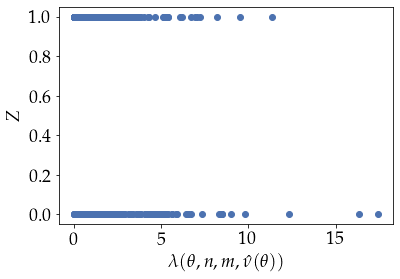

In [40]:
lambda_gen, Z = generate_Z_lambda(1000)

plt.scatter(lambda_gen, Z)
plt.xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$'); plt.ylabel(r'$Z$')

And our loss function was $L(t, model) =  (t - model(\theta, \nu, n, m))^2$ Where $t$ is the label of $Z$ value.



Here, with inputs $\{ \theta, \nu, N, M \}$, if we vary $\nu$ in the histogram as well as in the model we observe that:
1. In the case of MLE, there is insensetivity to $\nu$.
2. for the non-MLE, the probability does depend on $\nu$

However recall that the output of our model is the approxmation $E(Z|\theta, \nu, N, M)$ where $\{ \theta, \nu, N, M \}$ are the input features. Since $\nu$ is a nuissance parameter, we would like a function $\lambda(\theta,\nu, N,M)$ such that the expectation $E(Z|\theta, \nu, N, M)$ is independent of nuissance parameter $\nu$. One example is that we can impose this condition by

$$\frac{\partial E(Z|\theta,\nu,N,M)}{\partial \nu} =0                               \tag{1}$$
for all $\theta, N,M$. 

The question then becomes:

Can we replace $\lambda$ by a neural network with the condition above, but this time the neural network has an extra input $\hat{\theta}$. That is, the NN woud have $\{ \theta, \nu, N, M, \hat{\theta} \}$ as input. In doing this, wWee hope that:
1. If we put $\hat{\theta}$ as the MLE ($\hat{\theta}_{MLE}$), the NN for $\lambda$ would reproduce the analytical $\lambda$. 
2. We also hope that if we were to put non-MLE $\hat{\theta}_{non-MLE}$ the NN would have minimal sensitivity to $\nu$. 

This can be done, for example by adding an additional term to the loss function which is proportional to the square of the condition above

$$L(t, model) =  (t - model(\theta, \hat{\theta}, \nu, n, m))^2 + \frac{\kappa}{2} \ \left\| \frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu} \right\|^2 \tag{2}$$

Or
$$L(t, model) =  \left( sigmoid(t) - model(\theta, \hat{\theta}, \nu, n, m) \right)^2 + \frac{\kappa}{2} \ \left\| \frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu} \right\|^2 \tag{2}$$


We can impose the condition (1) by the additive term in the loss function (2), where $\kappa$ is a regularization constant, a non-negative hyperparameter that we can fit using validation data. For $\kappa=0$ we recover our original loss function. For $\kappa>0$, we restrict the size of the $L_2$ norm of $\frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu}$, i.e. we restrict $\| \frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu} \|^2$. The factor of $1/2$ is just by convention, since after we take the derivative of the loss function, the $2$ and the $1/2$ cancel out. Also, we use the square norm for computational convenience, it is much easier to compute for vectors than if we keep the square root in there!

(Recall that the $L_2$ norm for a vector $\mathbf{x}$ is like a Euclidean distance, $L_2=\|\mathbf{x}\|_{2}=\sqrt{\sum_{i=1}^{n} x_{i}^{2}}$, which is a case f the general $L_p$ norm $\|\mathbf{x}\|_{p}=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$. Further, norms are functions that tell us how big a vector is, so by adding $\left\| \frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu} \right|^2$ we are restricting the size of $\frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu}$ .)

The intuition for this is that if we have those two terms in the loss function, and we minimize w.r.t those two terms, that we are forcing the gradient descent into parameter space that has minimal sensetivity to $\nu$. Such that if there exists a statistic $\hat{\hat{\lambda}}$ which is perfectly independent of $\nu$, even for the non-MLE case, we expect that derivative to be 0 everywhere. 

-------------
### Attempt at implementation

Proposed solution:
*  initialize values for $\{ \theta,\nu,n,m \}$, requires_grad=True.
* Calculate a simple model (net) at those features, e.g. $model(\{ \theta,\nu,n,m \})$, requires_grad=True
* Detach the calculation of the weights
* calculate the gradient of model wrt nu, and use that in the loss function
$L(t, model) =  (t - model(\theta, \hat{\theta}, \nu, n, m))^2 + \frac{\kappa}{2} \ \left\| \frac{\partial model(\theta,\nu,\hat{\theta},N,M)}{\partial \nu} \right\|^2$.
* Now allow the calculation of the weights again (attach) and continue with SQG and other parts of the training, keeping in mind that the *step* which is invoked in the training is only with respect to the model parameters (weights) and not $\nu$.


### Let's consider a very simple solution: using a linear regression example

$$\hat{\mathbf{y}}=\mathbf{X} \mathbf{w}+b$$

Or, we could try $$\hat{\mathbf{y}}=sigmoid(\mathbf{X} \mathbf{w}+b)$$ since $\hat{y}$ is approximating $Z$ which is an indicator function.
Most popular loss function in regression is the squared loss 
$$l^{(i)}(\mathbf{w}, b)=\frac{1}{2}\left(\hat{y}^{(i)}-y^{(i)}\right)^{2} + \frac{\kappa}{2} \ \left\| \frac{\partial \hat{y}^{(i)}}{\partial \nu^{(i)}} \right\|^2$$
The half is just for convenience to cancel the 2 when we take derivative of the loss function.
The empirical risk, or objective function, over the entire dataset of $n$ examples is
$$R(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^{n} l^{(i)}(\mathbf{w}, b)$$
$$R(\mathbf{w},b)=\frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b+ \frac{\kappa}{2} \ \left\| \frac{\partial \hat{y}^{(i)}}{\partial \nu^{(i)}} \right\|^2-y^{(i)}\right)^{2}$$

We wish to minimize the training model to find the parameters $\mathbf{w}^*, b^*$ that minimize the total loss across all training examples
$$\mathbf{w}^{*}, b^{*}=\underset{\mathbf{w}, b}{\operatorname{argmin}} R(\mathbf{w}, b) .$$


Minibatch gradient descient: first randomly sample a monibatch $B$ consisting of a fixed number of training examples. We first randomly initialize $\mathbf{w}, b$ and then do the following updating
$$
\mathbf{w}  \leftarrow \mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b)=\mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b+ \frac{\kappa}{2} \ \left\| \frac{\partial \hat{y}^{(i)}}{\partial \nu^{(i)}} \right\|^2-y^{(i)}\right), $$

$$b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{b} l^{(i)}(\mathbf{w}, b)=b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b+ \frac{\kappa}{2} \ \left\| \frac{\partial \hat{y}^{(i)}}{\partial \nu^{(i)}} \right\|^2-y^{(i)}\right)$$

$|\mathcal{B}|$ represents the number of examples in the minibatch (batchsize), and $\eta$ is the learning rate.


In ML, in order to satisfty constrained optimization, there are several methods that have to do with convexity or penalties. 

Suppose you want to ensure that the weights $\mathbf{w}$ do not grow too large, then you add a term like $\frac{\lambda}{2} \|\mathbf{w} \|^2 $. This ensures that $\| \mathbf{w} \|^2 -r^2 \le 0$ for some radius $r$ and adjusting $\lambda$ allows us to vary the size of $\mathbf{w}$.

Another possibility is through the **forward propagation**. Forward propagation refers to the calculation and storage of intermediate variables from input to output layers. 

Here, it might be helpful to plot the computational graph to help us visualize the dependencies of operators and variables in the calculation.

### Activation Functions and Their Derivatives

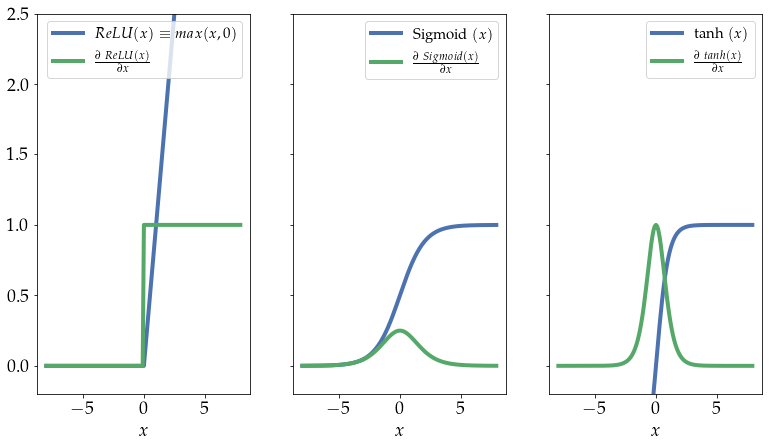

In [55]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(13,7))
axes = axes.flatten()
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
########RELU
relu = torch.relu(x)
axes[0].plot(x.detach(), relu.detach(),label=r'$ReLU(x) \equiv max(x,0)$')
#take derivative
relu.backward(torch.ones_like(x), retain_graph=True)
axes[0].plot(x.detach(), x.grad, label=r'$\frac{\partial \ ReLU(x)}{\partial x}$')
######SIGMOID
sigmoid = torch.sigmoid(x)
axes[1].plot(x.detach(), sigmoid.detach(),label=r'Sigmoid $(x)$')
# Clear out previous gradients
x.grad.data.zero_()
#take derivative
sigmoid.backward(torch.ones_like(x), retain_graph=True)
axes[1].plot(x.detach(), x.grad, label=r'$\frac{\partial \ Sigmoid(x)}{\partial x}$')
###tanh
tanh = torch.tanh(x)
axes[2].plot(x.detach(), tanh.detach(), label=r'tanh $(x)$')
x.grad.data.zero_()
tanh.backward(torch.ones_like(x),retain_graph=True)
axes[2].plot(x.detach(), x.grad, label=r'$\frac{\partial \ tanh(x)}{\partial x}$')

for ax in axes:
    ax.set_xlabel('$x$')
    ax.set_ylim(-0.2,2.5)
    ax.legend(fontsize=15)

In [13]:
MLE_TRUE_FILE = '../../tutorials/data1.db'
MLE_FALSE_FILE = '../../tutorials/data2.db'
#For both, Z for the two parameter problem is Z2
MLE=True

if MLE:
    datafile = MLE_TRUE_FILE
else:
    datafile = MLE_FALSE_FILE
    
data = jb.load(MLE_FALSE_FILE)
features = data[['theta', 'nu', 'N', 'M']]
target = data['Z2']
features

,theta,nu,N,M
0,11.755366,18.032972,4,2
1,10.864009,15.171221,5,7
2,1.642570,9.228130,1,1
3,2.952433,0.052783,0,9
4,4.697489,18.611853,9,0
...,...,...,...,...
509995,8.378316,3.066973,3,4
509996,12.520709,2.888144,2,5
509997,2.273833,1.704000,3,2
509998,17.995255,6.827394,4,3
